# all_sky_astrometry

<pre>
This the second step for all-sky calibration after vignetting 

Developed by Jia Yin et al. MNRAS 537,617-627 (2025)
"Calibration and applications of the all-sky camera at the Ali Observatory in Tibet"
National Astronomical Observatories, Chinese Academy of Sciences

Testing in 
Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = 'IMG_9467.CR2' 
tz = ZoneInfo('Europe/Paris')
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]

INPUT : RGB corrected images from RAW picture created by 'all_sky_vignetting.ipynb'
OUTPUT: WCS coordinates transformation as 'asdf' file and RGB 

Using all_sky_calibration_v4 by Jia Yin (2025/4/25) and reading the original picture
Using all_sky_calibration_v4 by Jia Yin (2025/4/25) and reading the RGB images corrected from vignetting

INPUT : RGB corrected images from RAW picture created by 'all_sky_vignetting.ipynb'
OUTPUT: WCS coordinates transformation as 'asdf' file and RGB. WCS in RA DEC 

version 2025/05/19
version 2025/05/21   
</pre>

In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import matplotlib.image as mpig
from astropy.wcs import WCS
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_TAN, Sky2Pix_STG, Sky2Pix_ARC, Sky2Pix_ZEA, Sky2Pix_SIN
#from astropy.modeling import projections
import asdf 
import matplotlib.pyplot as plt
import cv2
import rawpy

#### Functions

In [2]:
def check_projection(zen, r_real):
    str_proj = ['TAN', 'STG', 'ARC', 'ZEA', 'SIN']
    f_proj = [Sky2Pix_TAN(), Sky2Pix_STG(), Sky2Pix_ARC(), Sky2Pix_ZEA(), Sky2Pix_SIN()]
    if zen ==0:
        zen = 0.1
    zen_rad = np.deg2rad(zen)
    r_tan = np.tan(zen_rad) /zen_rad
    r_stg = np.tan(zen_rad/2.) *2/zen_rad
    r_arc = 1.
    r_zea = np.sin(zen_rad/2.) *2/zen_rad
    r_sin = np.sin(zen_rad)/zen_rad
    r_proj = np.array([r_tan, r_stg, r_arc, r_zea, r_sin])
    dr = np.abs(r_real -r_proj)
    r_id = np.argmin(dr)
    #print(r_proj)
    print(str_proj[r_id])
    return f_proj[r_id]

class HealpixData():
    def __init__(self, nside):
        img = np.arange(hp.nside2npix(nside))
        #lat, lon = hp.pix2ang(nside, img, nest=True)
        #self.lat = lat
        #self.lon = lon
        lon, lat = hp.pix2ang(nside, img, lonlat=True)
        self.lat = np.deg2rad(90. -lat)
        self.lon = np.deg2rad(lon)

class ImageData():
    def __init__(self, img=None, x=None, y=None):
        self.img = img
        self.x = x
        self.y = y

class all_sky_image():
    def __init__(self, filepath, sex_ext, rdata, proj_size):
        self.filepath = filepath
        self.sex = sex_ext
        self.rawdata = rdata
        self.fvalue = 0.
        self.cutdata = None
        self.hdata = HealpixData(1024) # healpix data for projection, nside=1024
        self.cen_rd = None # the (ra, dec) of image center
        self.bdata = HealpixData(4) # healpix data for rotation, nside=4
        self.divdeg = [45., 65., 90.] # the boundaries to divide the FoV into three segments
        self.divnum = [0., 0., 0.] # the number of healpix above the boundaries.
        self.func = lambda x,y,z: hp.vec2pix(1024,x,y,z)#,nest=True) # function for hdata
        self.new_gwcs = 0
        self.gwcs_radec = None
        self.tab = None
        self.dlon = None
        self.fproj = Sky2Pix_ARC() # the image projection, the default is ARC
        self.xproj = proj_size
        self.yproj = proj_size
        self.px = None
        self.py = None
        self.pdata = ImageData()
        self.frame = None        
        self.cen = [0, 0, 0]

    def _set_gwcs_radec(self, p_degree):
        tab_radec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
        xy = ((self.tab['field_x'],self.tab['field_y']))
        rd0 = self.cen_rd
        self.gwcs_radec = wcs_from_points(xy, tab_radec, proj_point=rd0,\
                             projection=self.fproj,poly_degree=p_degree, polynomial_type='polynomial')

    def _set_cutdata(self):
        col1 = self.cen[0]-self.cen[2]
        col2 = self.cen[0]+self.cen[2]
        row1 = self.cen[1]-self.cen[2]
        row2 = self.cen[1]+self.cen[2]
        self.cutdata = self.rawdata[row1:row2,col1:col2]             

    def _set_pxy(self):
        proj_nx = np.arange(self.xproj)
        proj_ny = np.arange(self.yproj)
        self.px, self.py = np.meshgrid(proj_nx, proj_ny)
        self.px = self.px.flatten()
        self.py = self.py.flatten()

    def _update_tab(self, r_radec):
        sra = str(round(r_radec.ra.deg,3))
        sdec = str(round(r_radec.dec.deg,3))
    
        sel_fit = fits.PrimaryHDU(np.array(self.pdata.img))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --width ' +str(self.xproj)+ ' --height ' +str(self.yproj) \
                            +' --ra '+sra+' --dec '+sdec+' --radius 10' \
                                +' --cpulimit 20 --scale-units arcsecperpix '\
                                    +' --scale-low 75 --scale-h 105 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            star_tab = fits.open(self.filepath+'sel_fit.corr')[1].data           
            os.remove(self.filepath+'sel_fit.corr') 
            star_x = griddata((self.px, self.py), self.pdata.x.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_y = griddata((self.px, self.py), self.pdata.y.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_tab['field_x'] = star_x
            star_tab['field_y'] = star_y
            self.tab = np.append(self.tab, star_tab)
        else:
            print("The region centered on the astronomical coordinates ("+sra+","+sdec+") could not be solved.")

    def _set_bdata(self):
        # [11.7, 23.6, 35.7, 48.2, 60.0, 70.5, 80.4, 90.0]
        # [   4,    8,   16,   16,   16,   16,   16,   16] 
        # If nside = 4, the first 7 circles need to be solved.
        coord = SkyCoord(self.bdata.lon, np.pi/2-self.bdata.lat, unit=(u.rad, u.rad))
        ang = self.cen_rd.separation(coord).deg
        id = np.argsort(ang)
        self.bdata.lat = self.bdata.lat[id]
        self.bdata.lon = self.bdata.lon[id]
        self.divnum[0] = len(self.bdata.lat[ang < self.divdeg[0]])
        self.divnum[1] = len(self.bdata.lat[ang < self.divdeg[1]])
        self.divnum[2] = len(self.bdata.lat[ang < self.divdeg[2]])

    def interpol_area(self):
        ny, nx = self.rawdata.shape
        xrange = np.arange(nx)
        yrange = np.arange(ny)

        fr = RegularGridInterpolator((yrange,xrange), self.rawdata ,method='linear', bounds_error=False)
        fdata = fr((self.pdata.y, self.pdata.x))
        self.pdata.img = np.nan_to_num(fdata, nan=0.0, posinf=0.0, neginf=0.0)
        if np.sum(np.isnan(fdata)) > len(fdata)*0.3:
            self.pdata.img = [0]
            print("This region is skipped.")
            #return self.pdata.img

    def rot_area(self, hrot):
        rot_proj = GnomonicProj(rot=(hrot[0],hrot[1]),xsize=self.xproj,ysize=self.yproj)
        glon = rot_proj.projmap(self.hdata.lon, self.func)
        glon = np.rad2deg(glon)
        glat = rot_proj.projmap(self.hdata.lat, self.func)
        glat = 90.-np.rad2deg(glat)
        gx, gy = self.gwcs_radec.backward_transform(glon,glat)
        self.pdata.x = gx
        self.pdata.y = gy
        if self.new_gwcs==0 :
            self.pdata.x = gx -self.cen[2] + self.cen[0]
            self.pdata.y = gy -self.cen[2] + self.cen[1]
        self.interpol_area()
    
    def estimate_center(self):
        # 1st to estimate center
        width, height = self.rawdata.shape
        self.cen = [round(height/2.), round(width/2.), round(width/10.)] ## xcenter, ycenter, radius
        if width > height :
            self.cen[2] = round(height/10.)

        self._set_cutdata()    
        sel_fit = fits.PrimaryHDU(np.array(self.cutdata))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --cpulimit 30 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            
            self.tab = fits.open(self.filepath+'sel_fit.corr')[1].data
            os.remove(self.filepath+'sel_fit.corr') 
            w = WCS(fits.open(self.filepath+'sel_fit.wcs')[0].header)
            cen_rd = w.wcs_pix2world([[self.cen[2], self.cen[2]]], 1)[0]
            self.cen_rd = SkyCoord(cen_rd[0], cen_rd[1], unit=(u.deg, u.deg))
            os.remove(self.filepath+'sel_fit.wcs') 

            self._set_gwcs_radec(p_degree=1)     
            ra0, dec0 = self.gwcs_radec(0,0)
            coord0 = SkyCoord(ra0, dec0, unit=(u.deg, u.deg))
            dist0 = self.cen[2]*np.sqrt(2.0)
            ang_dist = self.cen_rd.separation(coord0).deg
            self.fvalue = dist0 /np.deg2rad(ang_dist) # f = radius/theta
            print("x,y,radius,fvalue:",[self.cen, self.fvalue])
        else:
            print("The zenith region can not be solved.")    

    def get_tab(self):
        self._set_pxy()    
        self.estimate_center()    
        self._set_bdata()     
        self.tab['field_x'] = np.round(self.tab['field_x']-self.cen[2] + self.cen[0])
        self.tab['field_y'] = np.round(self.tab['field_y']-self.cen[2] + self.cen[1])
        print('The center area is solved.')

        for i in range(self.divnum[2]): 
            rot_lat = 90.-np.rad2deg(self.bdata.lat[i])
            rot_lon = np.rad2deg(self.bdata.lon[i])
            rot_radec = SkyCoord(self.bdata.lon[i], np.pi/2 -self.bdata.lat[i], unit=(u.rad, u.rad))
            print(f"@ lat:{round(rot_lat,3)}, lon:{round(rot_lon,3)}, count:{i+1}/{self.divnum[2]}")
            self.rot_area([rot_lon, rot_lat])    
            if len(self.pdata.img) == 1:
                continue 
            self._update_tab(rot_radec)

            if i==(self.divnum[0]-1) or i==(self.divnum[1]-1):
                uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
                self.tab = self.tab[u_ind]
                self.tab = self.tab[~np.isnan(self.tab['field_x'])]

                sradec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
                angular_distance = self.cen_rd.separation(sradec).deg
                zen_id = np.argmax(angular_distance)
                zen_deg = angular_distance[zen_id]
                print(zen_deg)
                rdis = np.sqrt((self.cen[0]-self.tab['field_x'][zen_id])**2.+(self.cen[1]-self.tab['field_y'][zen_id])**2.)
                r_real = rdis/np.deg2rad(zen_deg)/self.fvalue
                print(r_real)               
                self.fproj = check_projection(zen_deg, r_real)  
                self._set_gwcs_radec(p_degree=4)
                self.new_gwcs = 1

        # get the table 
        self.tab = self.tab[~np.isnan(self.tab['field_x'])]       
        uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
        self.tab = self.tab[u_ind]  
        self._set_gwcs_radec(p_degree=6)  

        self.tab = Table([self.tab['field_x'],self.tab['field_y'],\
                        self.tab['index_ra'],self.tab['index_dec'],\
                            self.tab['field_ra'],self.tab['field_dec'],\
                                self.tab['match_weight'],self.tab['MAG_AUTO'],self.tab['FLUX_AUTO']],\
                names=['field_x','field_y','index_ra','index_dec','field_ra','field_dec',\
                        'match_weight','mag_auto','flux_auto']) 

In [3]:
# Jia links
sex_ext = '/usr/local/bin/sex ' # source extractor
ipath = '/mnt/d/sel_cloud/clear2/'
fname = 't2020-10-19_04-24-26.jpg'
ifile = '2020-10-19_04-24-26.cr2' #

# Jaime links
sex_ext = 'sex ' # source extractor
ex_path = '' # exiftool path
ipath   = './'
ifile = 'IMG_9467.CR2' 


# convert the cr2 file to fits, or write them
#rawimg = rawpy.imread(ipath+ifile)
#idata = rawimg.raw_image
#irgb = convertBayer2RGB(idata, 'gbrg') # from var[10], CR2 CFA Pattern
#raw_b, raw_g, raw_r = cv2.split(irgb)

In [4]:
# EXIF metadata information

tags = '-MeasuredEV -LightValue -ISO -ExposureTime -Aperture -BlueBalance ' \
        +'-RedBalance -PerChannelBlackLevel -Lens -CanonImageType -CR2CFAPattern ' \
        +'-CreateDate -Orientation -SensorWidth -SensorHeight -RawMeasuredRGGB ' \
        +'-XResolution -YResolution -ExifVersion -ExposureProgram -Flash -FocusMode ' \
        +'-LensType -ControlMode -RawJpgSize -ColorTemperature -PictureStyle ' \
        +'-SensorLeftBorder -SensorTopBorder -SensorRightBorder -SensorBottomBorder -ModifyDate '
vtags = os.popen(ex_path+'exiftool -f -T '+tags +ipath+ifile).read()
vars = vtags.split('\t')
vars[-1] = vars[-1].split('\n')[0]
print(vars)
print('RGB Bayer matrix',vars[10])
print('datetime',vars[31])

['-0.62', '-7.3', '1600', '120.2', '3.5', '2.333008', '1.774414', '2048 2048 2048 2048', '8.0 mm', 'Canon EOS 6D Mark II', '[Red,Green][Green,Blue]', '2023:10:11 18:13:56', 'Rotate 90 CW', '6384', '4224', '-', '72', '72', '0230', 'Bulb', 'Off, Did not fire', 'Manual Focus (3)', 'Canon EF 28-80mm f/2.8-4L USM or Sigma Lens', 'Camera Local Control', 'Large', '5200', 'Auto', '132', '56', '6371', '4215', '2023:10:11 18:13:56']
RGB Bayer matrix [Red,Green][Green,Blue]
datetime 2023:10:11 18:13:56


#### Reading the RGGB images

In [5]:
# The headers are used later to save the clipped images

imafile = ifile.replace('.CR2','_R1_corr.fits')
header_r1 = fits.getheader(imafile)
raw_r1    = fits.getdata(imafile)
print(header_r1)

imafile = ifile.replace('.CR2','_G2_corr.fits')
header_g2 = fits.getheader(imafile)
raw_g2    = fits.getdata(imafile)
print(header_g2)

imafile = ifile.replace('.CR2','_G3_corr.fits')
header_g3 = fits.getheader(imafile)
raw_g3    = fits.getdata(imafile)
print(header_g3)

imafile = ifile.replace('.CR2','_B4_corr.fits')
header_b4 = fits.getheader(imafile)
raw_b4    = fits.getdata(imafile)
print(header_b4)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3132                                                  NAXIS2  =                 2090                                                  EXTEND  =                    T                                                  FILENAME= 'IMG_9467_R1_corr.fits'                                               HISTORY --------------------                                                    HISTORY 2025-05-10 10:38:25                                                     HISTORY Corrected from vignetting using flat-sigma-8-f35_EOS6DMII.fits          HISTORY R1 channel                                                              END                                                                                                                     

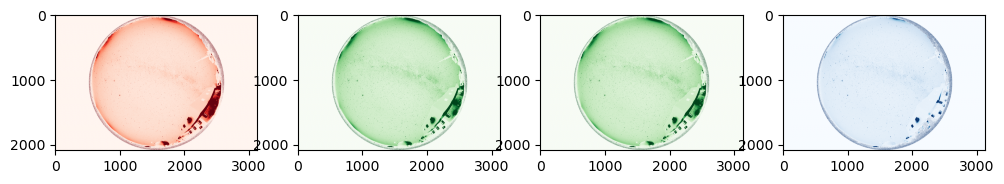

In [6]:
vmin = 0
vmax = 2000
fig,ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(raw_r1,cmap='Reds'  ,vmin=vmin,vmax=vmax)
ax[1].imshow(raw_g2,cmap='Greens',vmin=vmin,vmax=vmax)
ax[2].imshow(raw_g3,cmap='Greens',vmin=vmin,vmax=vmax)
ax[3].imshow(raw_b4,cmap='Blues' ,vmin=vmin,vmax=vmax)

In [7]:
result = all_sky_image(ipath, sex_ext, raw_g2, 600)
result.get_tab()


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



x,y,radius,fvalue: [[1566, 1045, 209], 716.5193798435873]
The center area is solved.
@ lat:41.81, lon:348.75, count:1/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:345.0, count:2/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:11.25, count:3/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:0.0, count:4/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:15.0, count:5/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:337.5, count:6/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:326.25, count:7/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:337.5, count:8/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:348.75, count:9/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:315.0, count:10/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:22.5, count:11/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:22.5, count:12/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:11.25, count:13/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:33.75, count:14/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:326.25, count:15/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:315.0, count:16/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:0.0, count:17/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:45.0, count:18/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:303.75, count:19/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:337.5, count:20/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:78.284, lon:315.0, count:21/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:292.5, count:22/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:78.284, lon:45.0, count:23/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:33.75, count:24/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:22.5, count:25/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:45.0, count:26/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:348.75, count:27/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:285.0, count:28/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:67.5, count:29/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



53.64873829563737
0.9535440339503732
ZEA
@ lat:41.81, lon:56.25, count:30/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:11.25, count:31/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:315.0, count:32/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:303.75, count:33/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:292.5, count:34/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:326.25, count:35/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:281.25, count:36/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:75.0, count:37/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:0.0, count:38/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:78.284, lon:225.0, count:39/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:337.5, count:40/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:78.284, lon:135.0, count:41/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:247.5, count:42/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:45.0, count:43/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:33.75, count:44/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:56.25, count:45/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:67.5, count:46/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:22.5, count:47/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:255.0, count:48/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:78.75, count:49/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:112.5, count:50/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:303.75, count:51/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (303.75,0.0) could not be solved.
@ lat:9.594, lon:292.5, count:52/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-19.471, lon:348.75, count:53/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:315.0, count:54/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (315.0,-9.594) could not be solved.
@ lat:19.471, lon:281.25, count:55/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



74.42378371013413
0.9115158553165162
ZEA
@ lat:30.0, lon:270.0, count:56/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:258.75, count:57/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-19.471, lon:11.25, count:58/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:105.0, count:59/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:202.5, count:60/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-19.471, lon:326.25, count:61/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:66.444, lon:157.5, count:62/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:56.25, count:63/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:45.0, count:64/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:9.594, lon:67.5, count:65/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:54.341, lon:225.0, count:66/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:101.25, count:67/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-19.471, lon:33.75, count:68/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:19.471, lon:78.75, count:69/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-30.0, lon:0.0, count:70/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:90.0, count:71/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-30.0, lon:337.5, count:72/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-9.594, lon:292.5, count:73/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (292.5,-9.594) could not be solved.
@ lat:54.341, lon:135.0, count:74/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:0.0, lon:281.25, count:75/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (281.25,0.0) could not be solved.
@ lat:41.81, lon:236.25, count:76/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-19.471, lon:303.75, count:77/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (303.75,-19.471) could not be solved.
@ lat:9.594, lon:270.0, count:78/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-30.0, lon:22.5, count:79/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (22.5,-30.0) could not be solved.
@ lat:19.471, lon:258.75, count:80/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:30.0, lon:247.5, count:81/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (247.5,30.0) could not be solved.
@ lat:54.341, lon:195.0, count:82/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:-30.0, lon:315.0, count:83/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (315.0,-30.0) could not be solved.
@ lat:54.341, lon:165.0, count:84/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



@ lat:41.81, lon:123.75, count:85/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (123.75,41.81) could not be solved.
@ lat:-19.471, lon:56.25, count:86/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (56.25,-19.471) could not be solved.
@ lat:-41.81, lon:348.75, count:87/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (348.75,-41.81) could not be solved.
@ lat:-9.594, lon:67.5, count:88/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (67.5,-9.594) could not be solved.
@ lat:0.0, lon:78.75, count:89/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (78.75,0.0) could not be solved.
@ lat:-41.81, lon:11.25, count:90/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (11.25,-41.81) could not be solved.
@ lat:41.81, lon:213.75, count:91/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (213.75,41.81) could not be solved.
@ lat:-30.0, lon:45.0, count:92/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (45.0,-30.0) could not be solved.
@ lat:30.0, lon:112.5, count:93/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (112.5,30.0) could not be solved.
@ lat:9.594, lon:90.0, count:94/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (90.0,9.594) could not be solved.
@ lat:-41.81, lon:326.25, count:95/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (326.25,-41.81) could not be solved.
@ lat:19.471, lon:101.25, count:96/96



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



The region centered on the astronomical coordinates (101.25,19.471) could not be solved.


/var/folders/2y/m_zlcv4x1ml0b6cm5_4f42y40000gn/T/ipykernel_64342/2544492063.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(result.rawdata))


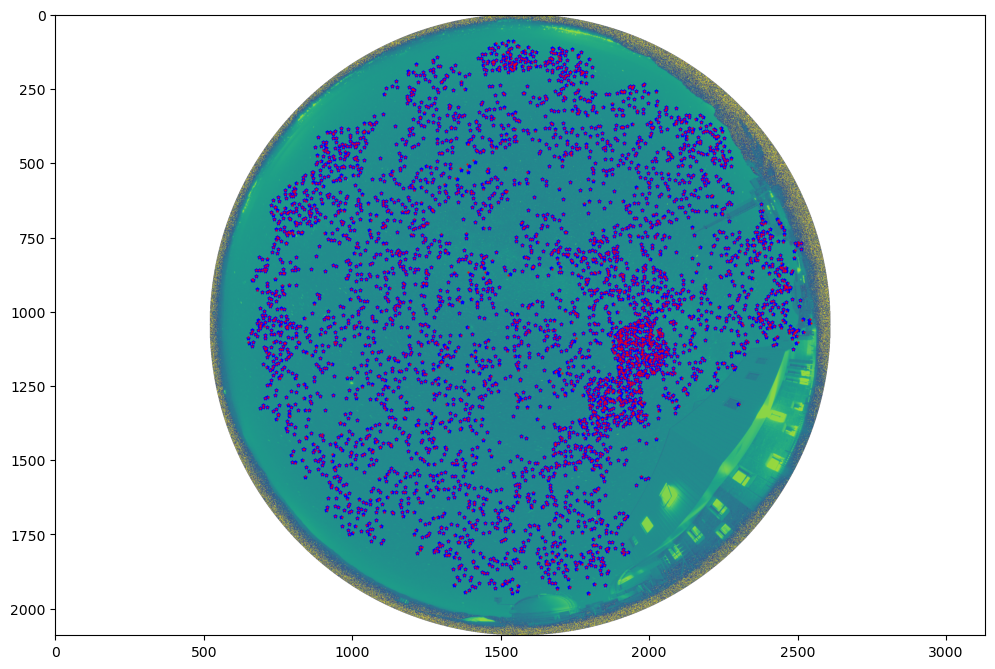

In [8]:
gx, gy = result.gwcs_radec.backward_transform(result.tab['index_ra'], result.tab['index_dec'])

fig,ax = plt.subplots(figsize=(12,12),dpi=100)
ax.imshow(np.log10(result.rawdata))
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(result.tab['field_x'],result.tab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()

In [9]:
result.tab[0:5]

field_x,field_y,index_ra,index_dec,field_ra,field_dec,match_weight,mag_auto,flux_auto
float64,float64,float64,float64,float64,float64,float64,float32,float32
1483.0214098925217,1243.8856927242787,0.09947500775947571,26.918230844110653,0.14541943929364315,26.924055411121497,0.9948402177243272,-11.832087,54054.824
1454.0703607898458,1597.473196051577,0.45599082038666666,-3.0274802738487816,0.44776272087583013,-3.0234521258903513,0.9929501628017006,-13.134615,179409.77
1452.6292729470085,1631.2067739803074,0.48997278653146364,-6.013975825713043,0.38984227109782554,-5.9874400800887075,0.8275971460453394,-13.642391,286389.12
1479.4831008771644,1241.8149002064883,0.5403080727950766,27.084399181374643,0.493394722274774,27.062195426761576,0.9933784269657592,-12.421916,93060.734
1446.1956272205607,1712.954223886075,0.5689044374585267,-13.407511672017636,0.6056604038430332,-13.404064053596576,0.9944756373668878,-11.0362425,25971.498


In [10]:
result.tab.info

<Table length=4314>
    name      dtype 
------------ -------
     field_x float64
     field_y float64
    index_ra float64
   index_dec float64
    field_ra float64
   field_dec float64
match_weight float64
    mag_auto float32
   flux_auto float32

#### Write resul to files

In [11]:
tree = {"wcs": result.gwcs_radec}
wcs_file = asdf.AsdfFile(tree)
ofile = ipath+'IMG_9467_wcs.asdf'
print(ofile)
wcs_file.write_to(ofile)
result.tab.write(ipath + 'IMG_9467_coords.csv',format='ascii.csv',overwrite=True)

./IMG_9467_wcs.asdf


#### Checking the astrometry

In [47]:
ofile = ipath+ifile.replace('.CR2','_wcs.asdf')  # the wcs obtained with the astrometry procedure
print(ofile)
asdf_file = asdf.open(ofile)
gwcs_radec = asdf_file.tree['wcs']

./IMG_9467_wcs.asdf


In [48]:
# get the standard RGB star catalog   (bright stars)
rgb_star_file = 'paper1_rgb_table_Ra-Dec.csv'
rgb_star = Table.read(rgb_star_file)
mask_var = rgb_star['Var.Name'] == '---'
tab_rgb = rgb_star[mask_var]         # Not using the variable stars

radec_rgb = SkyCoord(tab_rgb['RA'],tab_rgb['DEC'],unit=(u.deg, u.deg),frame='icrs')
# WCS transform in RA & DEC
##azalt_rgb = radec_rgb.transform_to(azalt_frame)

In [49]:
tab_rgb.info

<Table length=752>
      name        dtype 
---------------- -------
             #HR   int64
        Var.Name    str9
      standard_B float64
Error_standard_B float64
      standard_G float64
Error_standard_G float64
      standard_R float64
Error_standard_R float64
              RA float64
             DEC float64

In [53]:
# Positions of the RGB stars
x_rgb, y_rgb = gwcs_radec.backward_transform(tab_rgb['RA'], tab_rgb['DEC'])
# Positions stored into table
tab_rgb['x'] = np.round(x_rgb,2)
tab_rgb['y'] = np.round(y_rgb,2)

(1800.0, 600.0)

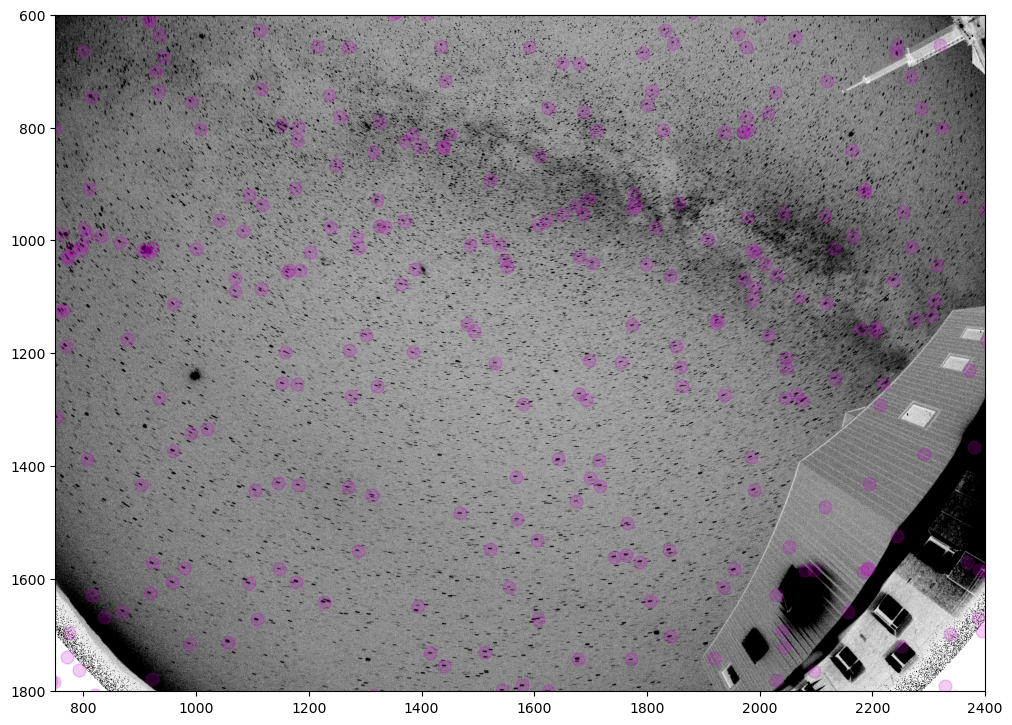

In [54]:
# Checking the astrometry
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(raw_g2,cmap='gray_r',vmin=0,vmax=900)
ax.scatter(tab_rgb['x'],tab_rgb['y'], c='m',s=85,marker='o',alpha=0.2)
plt.xlim(750,2400)
plt.ylim(1800,600)

(1200.0, 900.0)

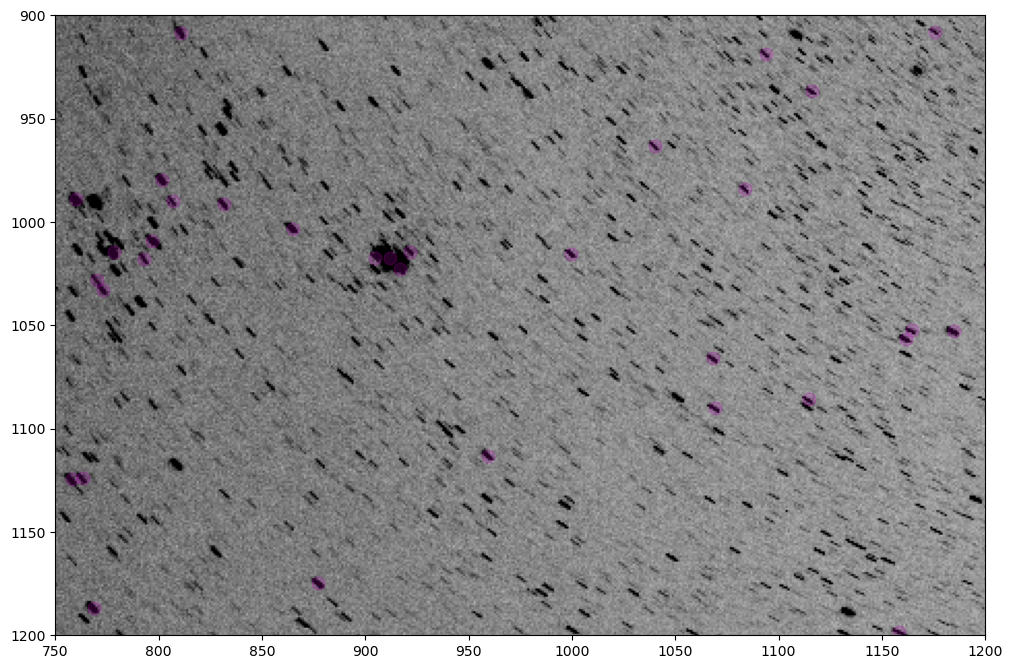

In [55]:
# Checking the astrometry
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(raw_g2,cmap='gray_r',vmin=0,vmax=900)
ax.scatter(tab_rgb['x'],tab_rgb['y'], c='m',s=85,marker='o',alpha=0.2)
plt.xlim(750,1200)
plt.ylim(1200,900)